# Erstellung der Benchmark Modelle
1. [Dickey-Fuller-Test](#1)
1. [Time Series Split](#2)
1. [AutoARIMA](#3)
1. [Exponential Smoothing](#4)
1. [Facebook Prophet](#5)
1. [Grafische Darstellung](#6)

In [1]:
!pip install darts

  Obtaining dependency information for darts from https://files.pythonhosted.org/packages/89/29/d5d086caa378240deb5d5e90982c772a8c4367e8688fb80754598ee35d14/darts-0.27.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.1 MB/s eta 0:00:00
  Obtaining dependency information for pmdarima>=1.8.0 from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for statsforecast>=1.4 from https://files.pythonhosted.org/packages/95/3c/c58057dde22b0280f3e07a68b681ca70ab7adc6cdaf5b0396277bfe3142b/statsforecast-1.7.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
  Obtaining dependency information

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from darts import TimeSeries
from darts.metrics import mae, rmse, mape

plt.style.use('ggplot')

print("Setup complete")

Setup complete


In [3]:
df = pd.read_csv("../input/ps-ds2/ps_ds2.csv")
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)
df_save = df.copy()
df = df[['use']]

df.head()

,use
timestamp,
2018-01-01 00:00:00,0.58575
2018-01-01 01:00:00,0.43750
2018-01-01 02:00:00,0.47875
2018-01-01 03:00:00,0.52275
2018-01-01 04:00:00,0.41825


<a id="1"></a>
## 1. Dickey-Fuller-Test
* https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda
* https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
* https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results

In [4]:
adf_result = adfuller(df.dropna())

test_statistic = adf_result[0]
crit_values = adf_result[4]
max_crit_value = max(crit_values.values())

print("Teststatistik: ", test_statistic)
print("Kritische Werte: ", crit_values)
print()

if test_statistic > max_crit_value: # Trend
    print(f"Die Teststatisik ist größer als die kritischen Werte bei 10%: {round(test_statistic, 2)} > {round(max_crit_value, 2)}")
    print("Die Nullhypothese kann nicht abgelehnt werden")
    print("Die Zeitreihe ist nicht stationär")
else: # Kein Trend
    print("Die Teststatistik ist kleiner als die kritischen Werte bei 1%, daher können wir mit 99%iger Sicherheit sagen, dass es sich um eine stationäre Zeitreihe handelt")
    print("Die Zeitreihe ist stationär")

Teststatistik:  -5.878320522991495
Kritische Werte:  {'1%': -3.4311082296069313, '5%': -2.8618750865101124, '10%': -2.566948361609558}

Die Teststatistik ist kleiner als die kritischen Werte bei 1%, daher können wir mit 99%iger Sicherheit sagen, dass es sich um eine stationäre Zeitreihe handelt
Die Zeitreihe ist stationär


<a id="2"></a>
## 2. Time Series Split
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

In [5]:
from matplotlib.patches import Patch
from sklearn.model_selection import TimeSeriesSplit

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


def plot_cv_indices(df, cv):
    """
    Erstellt eine Visualisierung für die Aufteilung in Trainings- und Testdaten durch den Time Series Split.
    :param df: Ein Dataframe, der eine Spalte 'use' mit realen Messwerten enthält.
    :param cv: Das TimeSeriesSplit-Objekt, das Informationen zu den folds enthält.
    """
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(df.use)):
        indices = np.array([np.nan] * len(df))
        indices[train_idx] = 0
        indices[test_idx] = 1
        ax.scatter(range(len(indices)), [fold + 0.5] * len(indices), c=indices, marker='_', lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
    n_splits = cv.get_n_splits()
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.2]
    )
    
    ax.legend(
        [Patch(color=cmap_cv(0.02)), Patch(color=cmap_cv(0.8))],
        ['Training set', 'Testing set'],
        loc=(1.02, 0.8)
    )
    
    ax.set_title("Time Series Split Visualisierung")

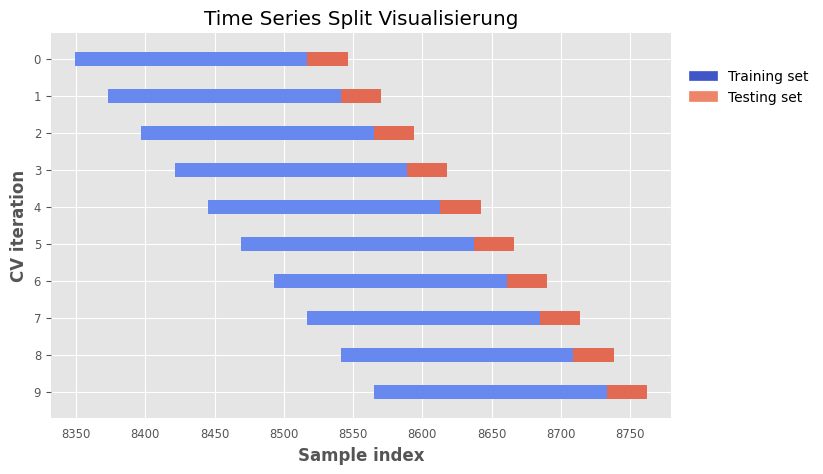

In [6]:
ONE_DAY = 24
ONE_WEEK = ONE_DAY * 7

tscv = TimeSeriesSplit(n_splits=10, max_train_size=ONE_WEEK, test_size=ONE_DAY)

plot_cv_indices(df, tscv)

In [7]:
def predict_daily(df, model):
    """
    Erstellt eine Vorhersage für die bereitgestellten Daten mit dem angegebenen Modell.
    :param df: Ein Dataframe, der einen Zeitstempel und eine Spalte 'use' mit realen Messwerten enthält.
    :param model: Ein angepasstes Modell aus der darts Bibliothek.
    :return: Eine Liste aller Vorhersagen für das entsprechende Modell.
    """
    # In darts TimeSeries Objekt konvertieren
    train_avg = df.use.head(ONE_WEEK).mean()
    series = TimeSeries.from_series(df, fill_missing_dates=True, freq='h', fillna_value=train_avg)
    
    historical_forecast = model.historical_forecasts(
        series=series,
        train_length=ONE_WEEK,
        forecast_horizon=ONE_DAY,
        last_points_only=False,
        stride=ONE_DAY,
        verbose=True
    )
    
    comb_df = pd.DataFrame()
    
    for fold in historical_forecast:
        preds = fold.pd_dataframe()
        comb_df = pd.concat([comb_df, preds])
    
    return comb_df


def eval_model(df, model_str):
    """
    Berechnet MAE, RMSE und MAPE zwischen den tatsächlichen und vorhergesagten Werten und gibt diese in der Konsole aus.
    :param df: Ein Dataframe, der eine Spalte 'use' mit tatsächlichen Messwerten und
               eine Spalte mit vorhergesagten Werten für das entsprechende Modell enthält.
    :param model_str: Der Name der Spalte für die vorhergesagten Werte.
    """
    # Filtern, um nur Zeilen mit nicht-NaN Werten in beiden Spalten zu behalten
    # df_filtered = df.dropna(subset=['use', model_str])
    
    # TROLLOLOL
    df_filtered = df[(df['use'] > 0) & (df[model_str] > 0)]
    
    # In darts TimeSeries Objekte konvertieren
    actual = TimeSeries.from_values(df_filtered['use'])
    predicted = TimeSeries.from_values(df_filtered[model_str])
    
    avg_mae = mae(actual, predicted)
    avg_rmse = rmse(actual, predicted)
    avg_mape = mape(actual, predicted)
    
    print(f"MAE: {round(avg_mae, 2)}, RMSE: {round(avg_rmse, 2)}, MAPE: {round(avg_mape, 2)} %")

<a id="3"></a>
## 3. AutoARIMA
### Setting m: https://alkaline-ml.com/pmdarima/tips_and_tricks.html#setting-m
Blog post: https://robjhyndman.com/hyndsight/seasonal-periods/
1. Saisonalitätsannahme: Der Wert m gibt die Länge der saisonalen Periode an. Bei m=24 geht das Modell davon aus, dass sich das Muster Ihrer Zeitreihe alle 24 Stunden wiederholt. Dies ist typisch für stündliche Daten, bei denen Sie tägliche Muster erwarten, wie z.B. höhere Aktivität während des Tages und niedrigere Aktivität in der Nacht.
2. Saisonale Differenzierung: Im Kontext von ARIMA-Modellen (und deren Erweiterungen wie SARIMA oder AutoARIMA) bezieht sich die saisonale Differenzierung auf die Anzahl der Differenzierungen, die erforderlich sind, um die saisonale Komponente der Zeitreihe stationär zu machen. Bei m=24 wird AutoARIMA versuchen, saisonale Effekte zu erkennen und zu modellieren, die sich im 24-Stunden-Rhythmus wiederholen.
3. Anwendungsbereiche: Ein solches Modell wäre beispielsweise sinnvoll bei der Analyse von Verkehrsdaten, Energieverbrauch, Webseitenaufrufen oder anderen stündlichen Messungen, bei denen tägliche Schwankungen eine Rolle spielen.
4. Modellierungskomplexität: Die Einbeziehung einer täglichen Saisonalität (m=24) in stündlichen Daten kann die Komplexität des Modells erhöhen. Es ist wichtig, die Modellpassung und -vorhersagen sorgfältig zu überprüfen, um sicherzustellen, dass das Modell die saisonalen Muster angemessen erfasst und nicht über- oder unterangepasst ist.

In [8]:
from darts.models import AutoARIMA

auto_arima_model = AutoARIMA(stationary=True, trend=None, seasonal=True)

arima_str = "arima_preds"
df_save[arima_str] = predict_daily(df, auto_arima_model)
eval_model(df_save, arima_str)

  0%|          | 0/358 [00:00<?, ?it/s]

MAE: 0.79, RMSE: 1.13, MAPE: 80.1 %


In [9]:
arima_model_x = AutoARIMA(stationary=True, trend=None, seasonal=True, m=24)

arima_str_x = "arima_preds_x"
df_save[arima_str_x] = predict_daily(df, arima_model_x)
eval_model(df_save, arima_str_x)

  0%|          | 0/358 [00:00<?, ?it/s]

MAE: 0.75, RMSE: 1.09, MAPE: 74.51 %


<a id="4"></a>
## 4. Exponential Smoothing

In [10]:
from darts.models import ExponentialSmoothing

es_model = ExponentialSmoothing(trend=None, seasonal_periods=24)

es_str = "es_preds"
df_save[es_str] = predict_daily(df, es_model)
eval_model(df_save, es_str)

  0%|          | 0/358 [00:00<?, ?it/s]

MAE: 0.91, RMSE: 1.34, MAPE: 90.65 %


<a id="5"></a>
## 5. Facebook Prophet

In [ ]:
from darts.models import Prophet

# Modell ohne Parameter ist schon sehr gut, seasonalities bringen kaum einen vorteil

prophet_model = Prophet(
    add_seasonalities=[ # Weekly automatisch generiert
        {
            'name': "hourly",
            'seasonal_periods': ONE_DAY,
            'fourier_order': 5 # für outcome nicht wirklich relevant. getestet mit zufälligen werten zwischen 1 und 100 und nur minimale abweichungen im 0,1% bereich
        },
        {
            'name': "monthly",
            'seasonal_periods': 12,
            'fourier_order': 5
        }
    ],
    # country_holidays='TX', --> 'Holidays in TX are not currently supported!' --> Ergebnis mit US schlechter als so
    suppress_stdout_stderror=True
)

prophet_str = "prophet_preds"
df_save[prophet_str] = predict_daily(df, prophet_model)
eval_model(df_save, prophet_str)

  0%|          | 0/358 [00:00<?, ?it/s]

21:51:32 - cmdstanpy - INFO - Chain [1] start processing
21:51:32 - cmdstanpy - INFO - Chain [1] done processing
21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] done processing
21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:33 - cmdstanpy - INFO - Chain [1] done processing
21:51:34 - cmdstanpy - INFO - Chain [1] start processing
21:51:34 - cmdstanpy - INFO - Chain [1] done processing
21:51:34 - cmdstanpy - INFO - Chain [1] start processing
21:51:34 - cmdstanpy - INFO - Chain [1] done processing
21:51:35 - cmdstanpy - INFO - Chain [1] start processing
21:51:35 - cmdstanpy - INFO - Chain [1] done processing
21:51:35 - cmdstanpy - INFO - Chain [1] start processing
21:51:35 - cmdstanpy - INFO - Chain [1] done processing
21:51:36 - cmdstanpy - INFO - Chain [1] start processing
21:51:36 - cmdstanpy - INFO - Chain [1] done processing
21:51:36 - cmdstanpy - INFO - Chain [1] start processing
21:51:36 - cmdstanpy - INFO - Chain [1]

MAE: 0.72, RMSE: 1.05, MAPE: 68.84 %


<a id="6"></a>
## 6. Grafische Darstellung

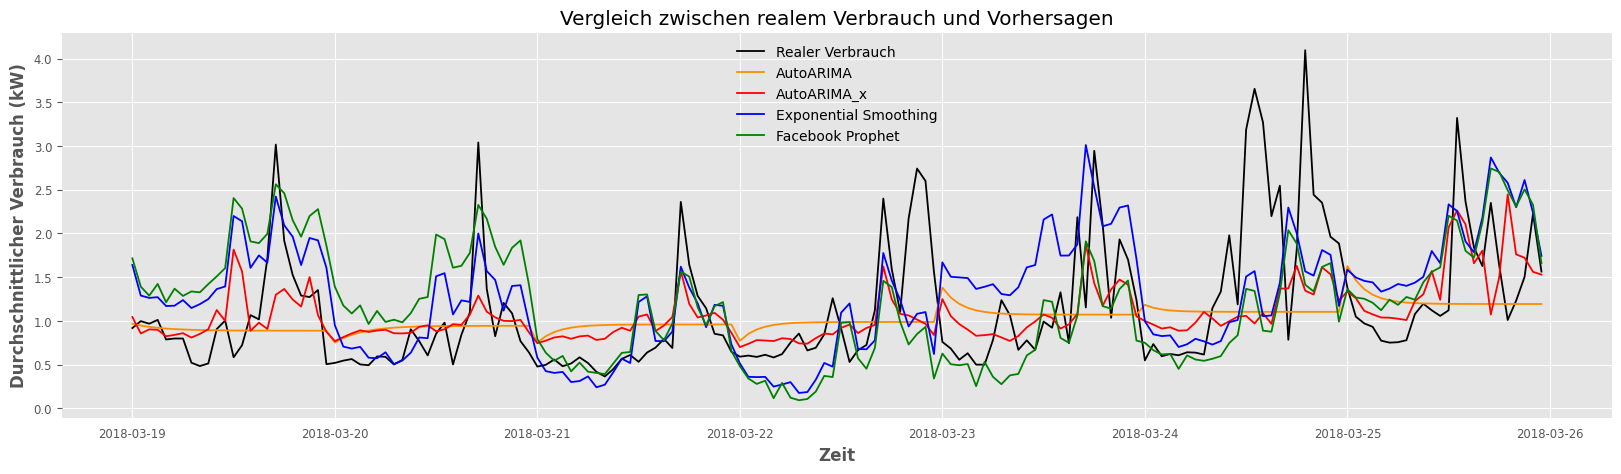

In [26]:
offset = 11
df_plot = df_save[ONE_WEEK*offset:ONE_WEEK*(offset+1)]

plt.figure(figsize=(20, 5))
plt.plot(df_plot.index, df_plot.use, color='black', label='Realer Verbrauch')
plt.plot(df_plot.index, df_plot.arima_preds, color='darkorange', label='AutoARIMA')
plt.plot(df_plot.index, df_plot.arima_preds_x, color='red', label='AutoARIMA_x')
plt.plot(df_plot.index, df_plot.es_preds, color='blue', label='Exponential Smoothing')
plt.plot(df_plot.index, df_plot.prophet_preds, color='green', label='Facebook Prophet')
plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
plt.xlabel('Zeit')
plt.ylabel('Durchschnittlicher Verbrauch (kW)')
plt.legend()
plt.show()

In [ ]:
# Als csv-Datei speichern
df_save.to_csv('ps_ds3.csv')